# Model Training

This file is to be used by each person to train/test their model on test datasets.

Each model should contain a brief **Hypothesis** about this model's performance on the final project, basically a
shorthand/rough draft version of the one we will put on the final project, including a justification for why you
think the model will perform well or poorly. Graphs of predictions vs the testing data are welcome!

&nbsp;

## Imports

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

&nbsp;

### Test Data Generation

In [7]:
# The size of the dataset
dataset_size = 200

# The test set percentages
test_size = 0.2

#### Generate a Quadratic Distribution

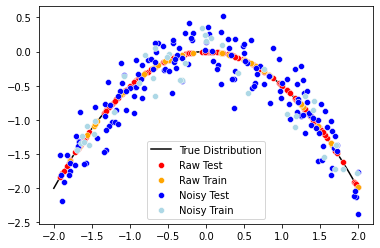

In [8]:
# Create the X points
quad_X = np.random.uniform(low=-2, high=2, size=dataset_size)

# Create the raw y values
quad_y = -0.5 * quad_X**2
quad_X_train, quad_X_test, quad_y_train, quad_y_test = train_test_split(quad_X, quad_y, test_size=test_size)

# Create a version of the y values with gaussian noise added
quad_y_noisy = quad_y + np.random.normal(0, 0.25, dataset_size)
quad_X_noisy_train, quad_X_noisy_test, quad_y_noisy_train, quad_y_noisy_test = train_test_split(quad_X, quad_y_noisy, test_size=test_size)

# Find the true distribution line
quad_X_true = np.linspace(-2, 2, 1000)
quad_y_true = -0.5*quad_X_true**2

# Plot the dataset
sns.lineplot(x=quad_X_true, y=quad_y_true, color='black', zorder=0) # The true distribution
sns.scatterplot(x=quad_X_train, y=quad_y_train, color='red') # The training points
sns.scatterplot(x=quad_X_test, y=quad_y_test, color='orange') # The testing points
sns.scatterplot(x=quad_X_noisy_train, y=quad_y_noisy_train, color='blue') # The noisy training points
sns.scatterplot(x=quad_X_noisy_test, y=quad_y_noisy_test, color='lightblue') # The noisy testing points
plt.legend(labels=['True Distribution', 'Raw Test', 'Raw Train', 'Noisy Test', 'Noisy Train'])

#### Generate a Sine Distribution

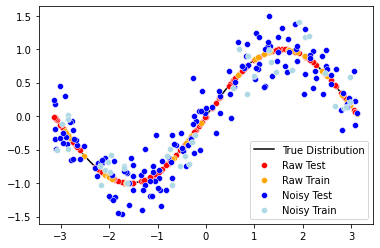

In [9]:
# Create the X points
sin_X = np.random.uniform(low=-math.pi, high=math.pi, size=dataset_size)

# Create the raw y values
sin_y = np.sin(sin_X)
sin_X_train, sin_X_test, sin_y_train, sin_y_test = train_test_split(sin_X, sin_y, test_size=test_size)

# Create a version of the y values with gaussian noise added
sin_y_noisy = sin_y + np.clip(np.random.normal(0, 0.25, dataset_size), -1, 1)
sin_X_noisy_train, sin_X_noisy_test, sin_y_noisy_train, sin_y_noisy_test = train_test_split(sin_X, sin_y_noisy, test_size=test_size)

# Find the true distribution line
sin_X_true = np.linspace(-math.pi, math.pi, 1000)
sin_y_true = np.sin(sin_X_true)

# Plot the dataset
sns.lineplot(x=sin_X_true, y=sin_y_true, color='black', zorder=0) # The true distribution
sns.scatterplot(x=sin_X_train, y=sin_y_train, color='red') # The training points
sns.scatterplot(x=sin_X_test, y=sin_y_test, color='orange') # The testing points
sns.scatterplot(x=sin_X_noisy_train, y=sin_y_noisy_train, color='blue') # The noisy training points
sns.scatterplot(x=sin_X_noisy_test, y=sin_y_noisy_test, color='lightblue') # The noisy testing points
plt.legend(labels=['True Distribution', 'Raw Test', 'Raw Train', 'Noisy Test', 'Noisy Train'])

#### Generate a Polynomial Distribution

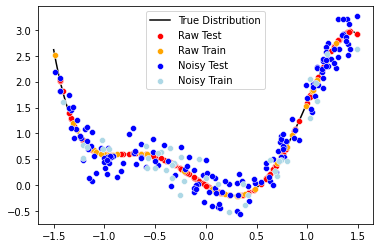

In [10]:
# The polynomial degree scalars
deg = [-0.9, 0.1, 2.6, 1, -1.2]

# Create the X points
poly_X = np.random.uniform(low=-1.5, high=1.5, size=dataset_size)

# Create the raw y values
poly_y = deg[0] * poly_X**5 + deg[1] * poly_X**4 + deg[2] * poly_X**3 + deg[3] * poly_X**2 + deg[4] * poly_X
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(poly_X, poly_y, test_size=test_size)

# Create a version of the y values with gaussian noise added
poly_y_noisy = poly_y + np.clip(np.random.normal(0, 0.25, dataset_size), -1, 1)
poly_X_noisy_train, poly_X_noisy_test, poly_y_noisy_train, poly_y_noisy_test = train_test_split(poly_X, poly_y_noisy, test_size=test_size)

# Find the true distribution line
poly_X_true = np.linspace(-1.5, 1.5, 1000)
poly_y_true = deg[0] * poly_X_true**5 + deg[1] * poly_X_true**4 + deg[2] * poly_X_true**3 + deg[3] * poly_X_true**2 + deg[4] * poly_X_true

# Plot the dataset
sns.lineplot(x=poly_X_true, y=poly_y_true, color='black', zorder=0) # The true distribution
sns.scatterplot(x=poly_X_train, y=poly_y_train, color='red') # The training points
sns.scatterplot(x=poly_X_test, y=poly_y_test, color='orange') # The testing points
sns.scatterplot(x=poly_X_noisy_train, y=poly_y_noisy_train, color='blue') # The noisy training points
sns.scatterplot(x=poly_X_noisy_test, y=poly_y_noisy_test, color='lightblue') # The noisy testing points
plt.legend(labels=['True Distribution', 'Raw Test', 'Raw Train', 'Noisy Test', 'Noisy Train'])

#### Generate a Wave Distribution

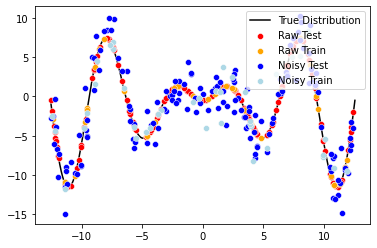

In [11]:
# Create the X points
wave_X = np.random.uniform(low=-4*math.pi, high=4*math.pi, size=dataset_size)

# Create the raw y values
wave_y = wave_X * np.sin(wave_X) - 0.5
wave_X_train, wave_X_test, wave_y_train, wave_y_test = train_test_split(wave_X, wave_y, test_size=test_size)

# Create a version of the y values with gaussian noise added
wave_y_noisy = wave_y + np.clip(np.random.normal(0, 2, dataset_size), -5, 5)
wave_X_noisy_train, wave_X_noisy_test, wave_y_noisy_train, wave_y_noisy_test = train_test_split(wave_X, wave_y_noisy, test_size=test_size)

# Find the true distribution line
wave_X_true = np.linspace(-4*math.pi, math.pi*4, 1000)
wave_y_true = wave_X_true * np.sin(wave_X_true) - 0.5

# Plot the dataset
sns.lineplot(x=wave_X_true, y=wave_y_true, color='black', zorder=0, sort=False) # The true distribution
sns.scatterplot(x=wave_X_train, y=wave_y_train, color='red') # The training points
sns.scatterplot(x=wave_X_test, y=wave_y_test, color='orange') # The testing points
sns.scatterplot(x=wave_X_noisy_train, y=wave_y_noisy_train, color='blue') # The noisy training points
sns.scatterplot(x=wave_X_noisy_test, y=wave_y_noisy_test, color='lightblue') # The noisy testing points
plt.legend(labels=['True Distribution', 'Raw Test', 'Raw Train', 'Noisy Test', 'Noisy Train'], loc='upper right')

#### Generate a Mixture Distribution

This distribution is a mixture of the Polynomial and Wave distributions.

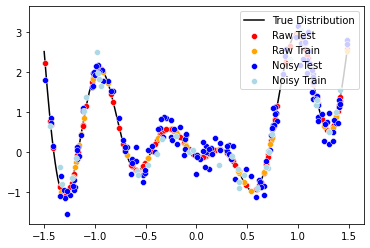

In [12]:
# Create the X points
mixture_X = np.copy(poly_X)

# Create the raw y values
poly_to_wave_X = mixture_X * 4 * math.pi / 1.5
mixture_y = poly_y + ((poly_to_wave_X * np.sin(poly_to_wave_X) - 0.5)/5)
mixture_X_train, mixture_X_test, mixture_y_train, mixture_y_test = train_test_split(mixture_X, mixture_y, test_size=test_size)

# Create a version of the y values with gaussian noise added
mixture_y_noisy = mixture_y + np.clip(np.random.normal(0, 0.25, dataset_size), -4, 4)
mixture_X_noisy_train, mixture_X_noisy_test, mixture_y_noisy_train, mixture_y_noisy_test = train_test_split(mixture_X, mixture_y_noisy, test_size=test_size)

# Find the true distribution line
mixture_X_true = np.copy(poly_X_true)
mixture_y_true = poly_y_true + (wave_y_true/5)

# Plot the dataset
sns.lineplot(x=mixture_X_true, y=mixture_y_true, color='black', zorder=0, sort=False) # The true distribution
sns.scatterplot(x=mixture_X_train, y=mixture_y_train, color='red') # The training points
sns.scatterplot(x=mixture_X_test, y=mixture_y_test, color='orange') # The testing points
sns.scatterplot(x=mixture_X_noisy_train, y=mixture_y_noisy_train, color='blue') # The noisy training points
sns.scatterplot(x=mixture_X_noisy_test, y=mixture_y_noisy_test, color='lightblue') # The noisy testing points
plt.legend(labels=['True Distribution', 'Raw Test', 'Raw Train', 'Noisy Test', 'Noisy Train'], loc='upper right')

#### Create a List of All Distributions

In [13]:
# A list of nominative labels for each distributions
distribution_list = ['Quadratic', 'Sine', 'Polynomial', 'Wave', 'Mixture']

# A list of plot bounds for each distribution
plot_bounds = [
    [(-2, 2), (-3.2, 3.2), (-1.6, 1.6), (-14, 14), (-1.8, 1.8)],
    [(-2.75, 0.75), (1.5, -1.5), (-1, 3), (-15, 10), (-1.5, 3.2)]
]

# A list of the true distributions
X_true_list = [quad_X_true, sin_X_true, poly_X_true, wave_X_true, mixture_X_true]
y_true_list = [quad_y_true, sin_y_true, poly_y_true, wave_y_true, mixture_y_true]

# A list the raw training data
X_train_list = [quad_X_train, sin_X_train, poly_X_train, wave_X_train, mixture_X_train]
y_train_list = [quad_y_train, sin_y_train, poly_y_train, wave_y_train, mixture_y_train]

# A list the raw testing data
X_test_list = [quad_X_test, sin_X_test, poly_X_test, wave_X_test, mixture_X_test]
y_test_list = [quad_y_test, sin_y_test, poly_y_test, wave_y_test, mixture_y_test]

# A list the noisy training data
X_noisy_train_list = [quad_X_noisy_train, sin_X_noisy_train, poly_X_noisy_train, wave_X_noisy_train, mixture_X_noisy_train]
y_noisy_train_list = [quad_y_noisy_train, sin_y_noisy_train, poly_y_noisy_train, wave_y_noisy_train, mixture_y_noisy_train]

# A list the noisy testing data
X_noisy_test_list = [quad_X_noisy_test, sin_X_noisy_test, poly_X_noisy_test, wave_X_noisy_test, mixture_X_noisy_test]
y_noisy_test_list = [quad_y_noisy_test, sin_y_noisy_test, poly_y_noisy_test, wave_y_noisy_test, mixture_y_noisy_test]

&nbsp;

### Gaussian Process Regression


#### Create a custom Gaussian Regressor


#### Train on Each Dataset

In [36]:
# Create an RBF kernel
kernel = 1 * ExpSineSquared() + WhiteKernel()

# Create a model for each distribution
models = [GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9) for i in range(10)]

# Create a Pipeline for each model
pipes = [make_pipeline(StandardScaler(), model) for model in models]

# Fit the models to the data
for i, model in enumerate(models):

    # Find the dataset to use
    if i < 5: data_X, data_y = X_train_list[i].reshape(-1, 1), y_train_list[i]
    else: data_X, data_y = X_noisy_train_list[i-5].reshape(-1, 1), y_noisy_train_list[i-5]
        
    # Fit the data
    pipes[i].fit(data_X, data_y)

C:\Users\Will Sumerfield\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\Will Sumerfield\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Will Sumerfield\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Py

#### Predict on the Test Data, and Find the MSE

In [37]:
# Find each model's prediction and error on the test set for each distribution
model_predictions = np.array([None]*20)
model_errors = np.zeros(10)
for i in range(len(model_predictions)):

    # Predict on the raw distributions
    if i < 5:
        pipe = pipes[i]
        model_predictions[i] = pipe.predict(X_test_list[i].reshape(-1, 1))
        model_errors[i] = mean_squared_error(y_test_list[i], model_predictions[i])

    # Predict on the noisy distributions
    elif i < 10:
        pipe = pipes[i]
        model_predictions[i] = pipe.predict(X_noisy_test_list[i-5].reshape(-1, 1))
        model_errors[i] = mean_squared_error(y_test_list[i-5], model_predictions[i])

    # Predict the raw model curve
    elif i < 15:
        pipe = pipes[i-10]
        model_predictions[i] = pipe.predict(X_true_list[i % 5].reshape(-1, 1))

    # Predict the noisy model curve
    else:
        pipe = pipes[i-10]
        model_predictions[i] = pipe.predict(X_true_list[i % 5].reshape(-1, 1))

#### Display each Model's MSE and Plot the Predictions

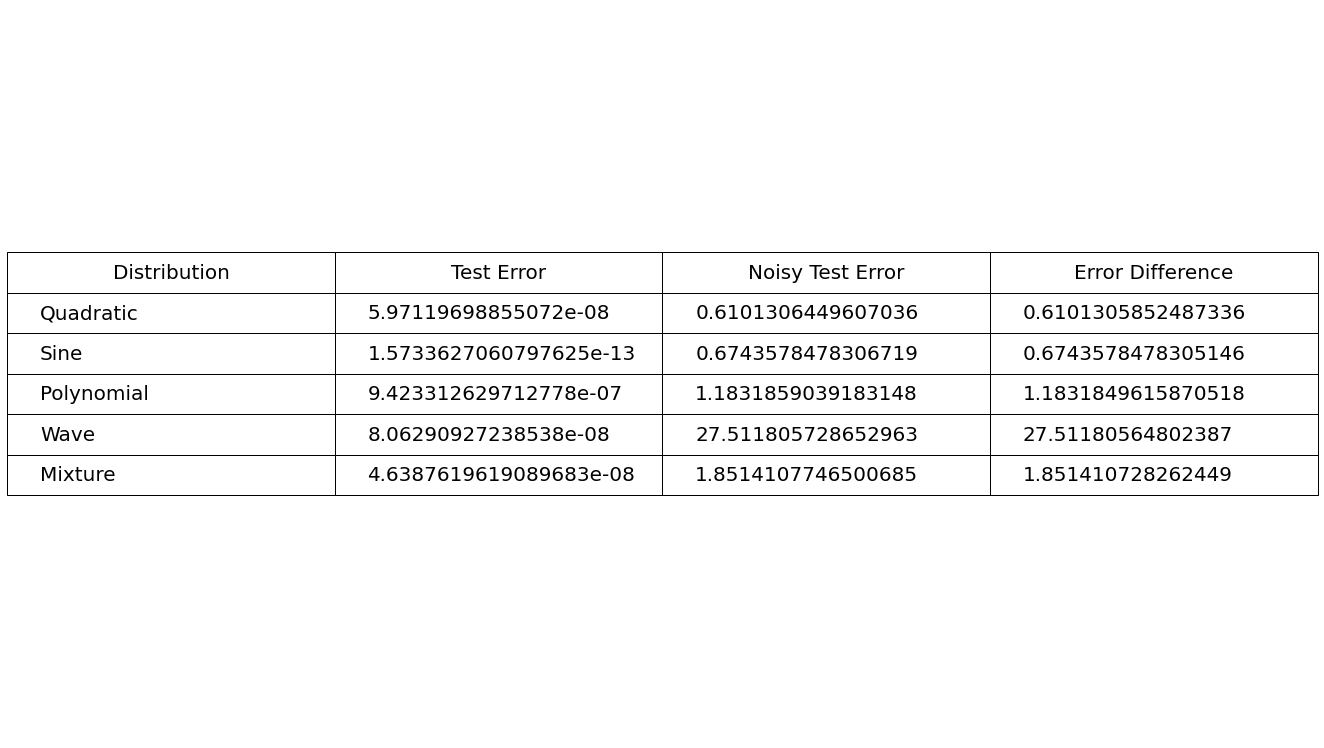

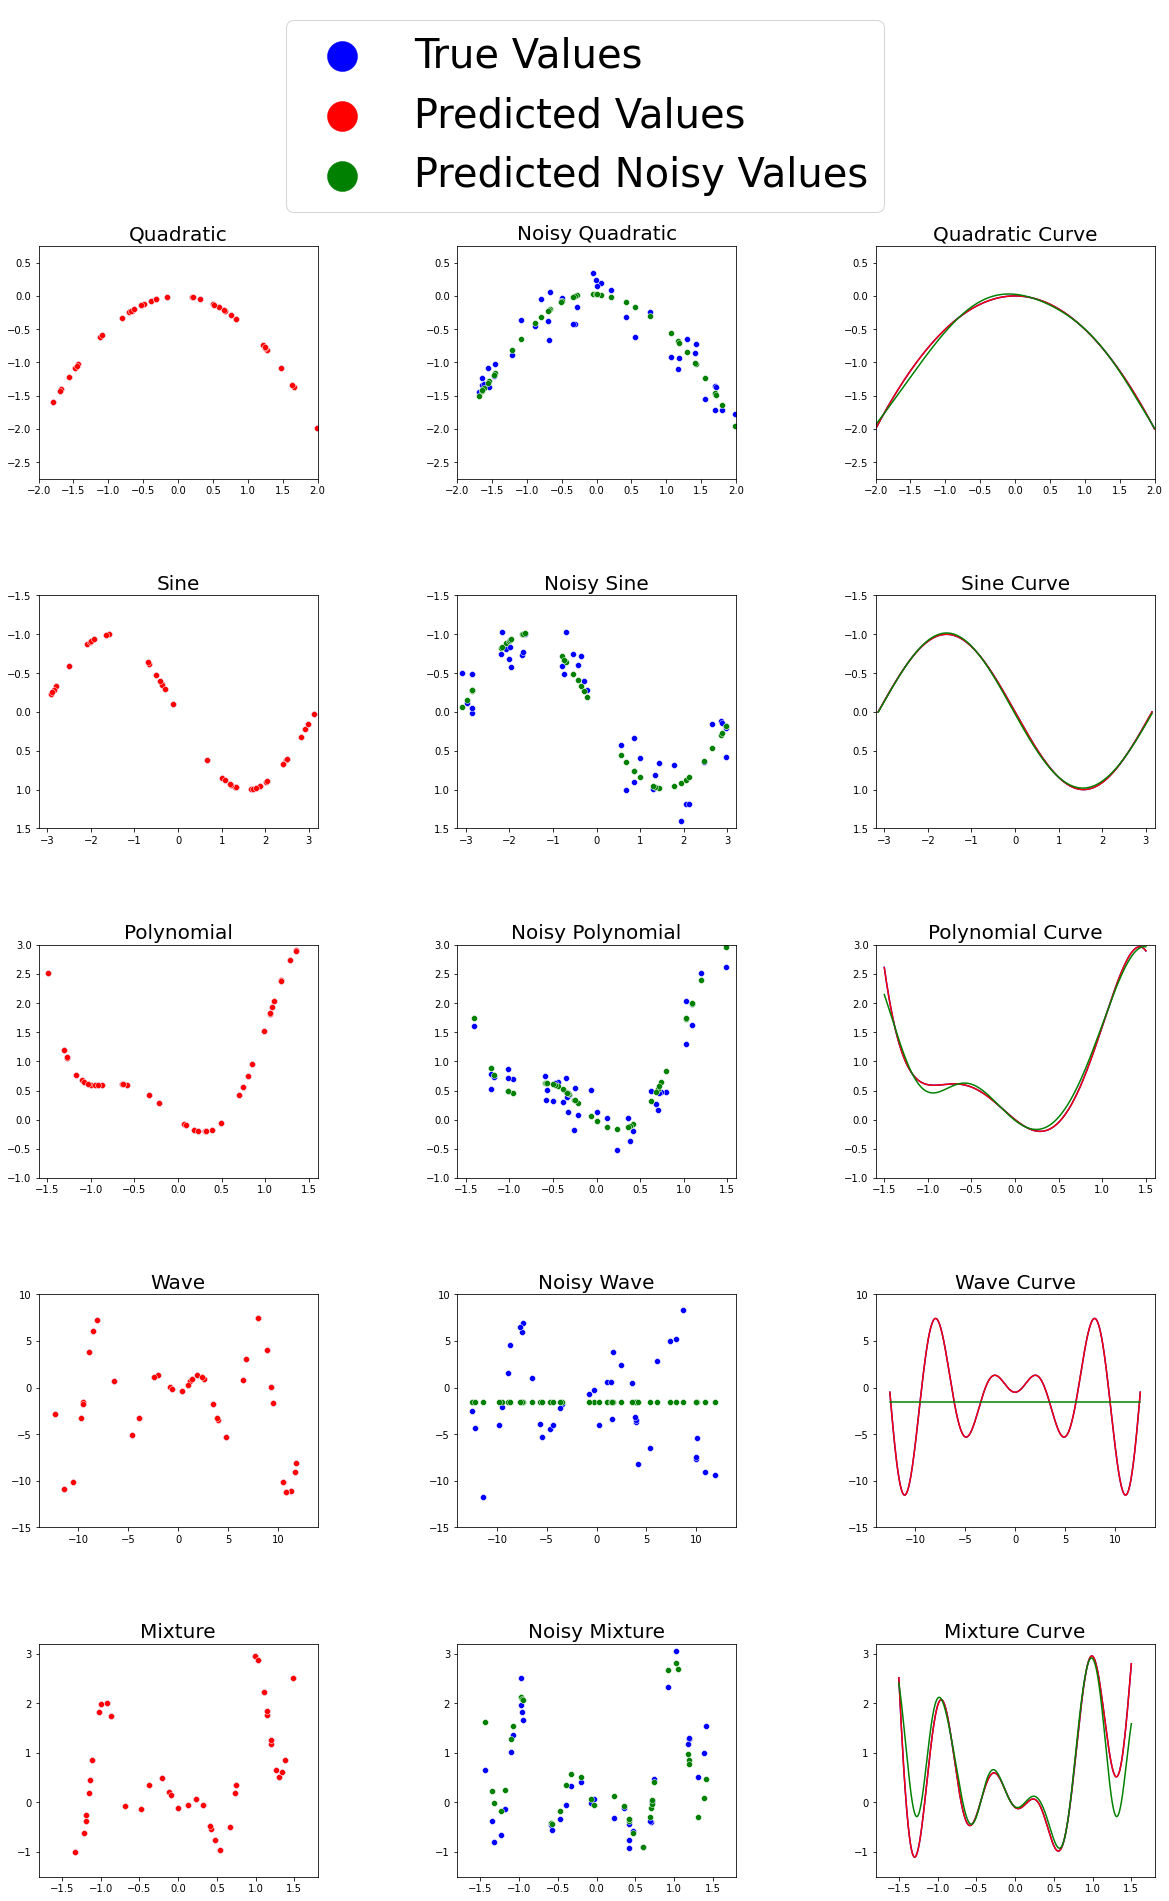

In [38]:
# Display the MSE
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=np.flip(np.rot90(np.array([distribution_list, model_errors[0:5], 
                                                     model_errors[5:10], model_errors[5:10] - model_errors[0:5]])), 0),
                 colLabels=['Distribution', 'Test Error', 'Noisy Test Error', 'Error Difference'], loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(20)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

# Plot the model's predictions
fig, axes = plt.subplots(5, 3, figsize=(20,30), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
for i, axis in enumerate(np.flip(np.rot90(axes), axis=0).flatten()):

    # Display the distribution name and markings
    if i < 5: title = distribution_list[i % 5]
    elif i < 10: title = 'Noisy ' + distribution_list[i % 5]
    else: title = distribution_list[i % 5] + ' Curve'
    axis.set_title(title, fontsize=20)

    # Find the values to plot
    if i < 5: data_X = X_test_list[i]
    elif i < 10: data_X = X_noisy_test_list[i-5]
    else: data_X = X_true_list[i % 5]

    if i < 5: data_y = y_test_list[i]
    elif i < 10: data_y = y_noisy_test_list[i-5]
    else: data_y = y_true_list[i % 5]

    # Find the color of the predicted values
    if i < 5: color = 'red'
    else: color = 'green'

    # Plot the test values
    if i < 10: sns.scatterplot(x=data_X, y=data_y, ax=axis, color='blue')
    else: sns.lineplot(x=data_X, y=data_y, ax=axis, color='blue', sort=False)

    # Plot the predicted values
    if i < 10: sns.scatterplot(x=data_X, y=model_predictions[i], ax=axis, color=color)
    else:
        sns.lineplot(x=data_X, y=model_predictions[i], ax=axis, color='red', sort=False)
        sns.lineplot(x=data_X, y=model_predictions[i+5], ax=axis, color='green', sort=False)

    # Set the plot limits
    axis.set_xlim(plot_bounds[0][i % 5])
    axis.set_ylim(plot_bounds[1][i % 5])

leg = fig.legend(labels=['True Values', 'Predicted Values', 'Predicted Noisy Values'],
                 markerscale=5,loc='upper center', prop={'size': 40})
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
leg.legendHandles[2].set_color('green')
plt.show()

&nbsp;

### Polynomial Regression


#### Create a custom Polynomial Regression


#### Train on Each Dataset

In [52]:
# Create a model for each distribution
models = [PolynomialFeatures(degree=14, include_bias=True) for i in range(10)]

# Create a linear regression for each model
linear_models = [LinearRegression() for model in models]

# Create a Pipeline for each model
pipes = [make_pipeline(StandardScaler(), model, linear_model) for model, linear_model in zip(models, linear_models)]

# Fit the models to the data
for i, model in enumerate(models):

    # Find the dataset to use
    if i < 5: data_X, data_y = X_train_list[i].reshape(-1, 1), y_train_list[i]
    else: data_X, data_y = X_noisy_train_list[i-5].reshape(-1, 1), y_noisy_train_list[i-5]

    # Fit the data
    pipes[i].fit(data_X, data_y)

#### Predict on the Test Data, and Find the MSE

In [53]:
# Find each model's prediction and error on the test set for each distribution
model_predictions = np.array([None]*20)
model_errors = np.zeros(10)
for i in range(len(model_predictions)):

    # Predict on the raw distributions
    if i < 5:
        pipe = pipes[i]
        model_predictions[i] = pipe.predict(X_test_list[i].reshape(-1, 1))
        model_errors[i] = mean_squared_error(y_test_list[i], model_predictions[i])

    # Predict on the noisy distributions
    elif i < 10:
        pipe = pipes[i]
        model_predictions[i] = pipe.predict(X_noisy_test_list[i-5].reshape(-1, 1))
        model_errors[i] = mean_squared_error(y_test_list[i-5], model_predictions[i])

    # Predict the raw model curve
    elif i < 15:
        pipe = pipes[i-10]
        model_predictions[i] = pipe.predict(X_true_list[i % 5].reshape(-1, 1))

    # Predict the noisy model curve
    else:
        pipe = pipes[i-10]
        model_predictions[i] = pipe.predict(X_true_list[i % 5].reshape(-1, 1))

#### Display each Model's MSE and Plot the Predictions

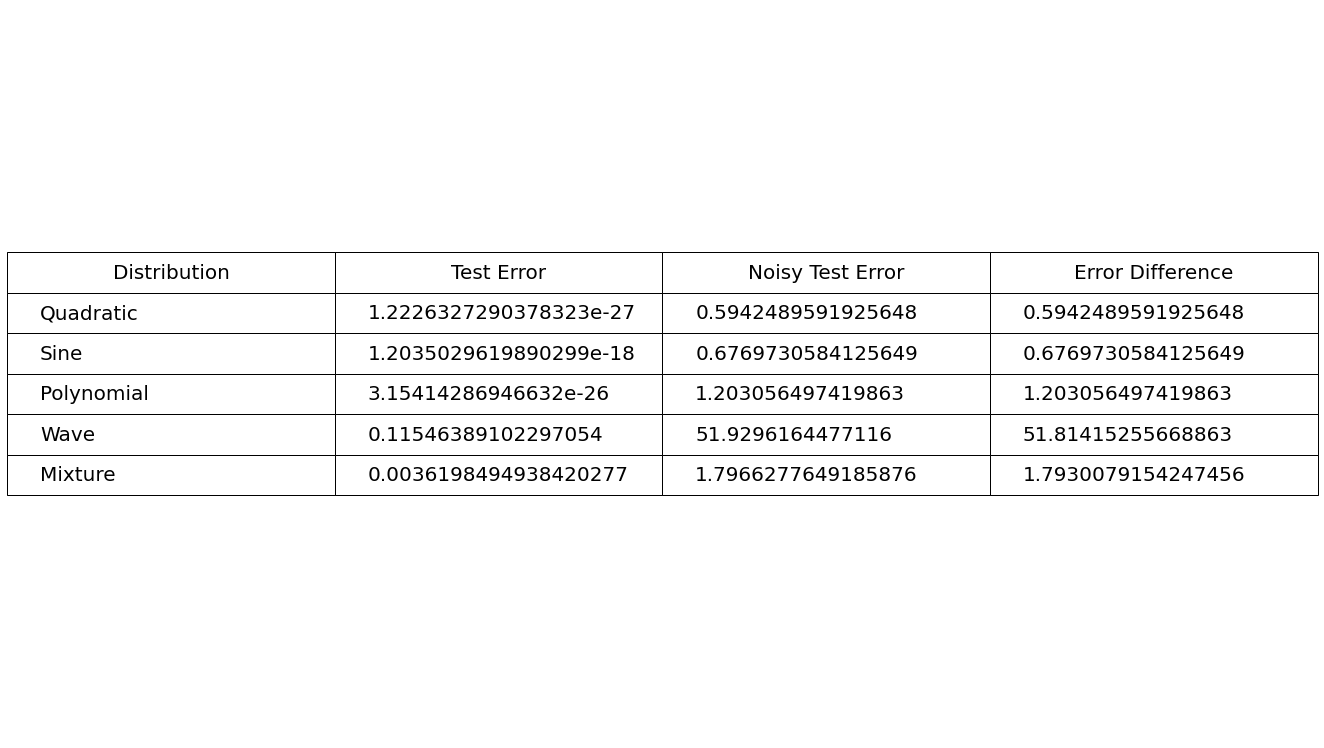

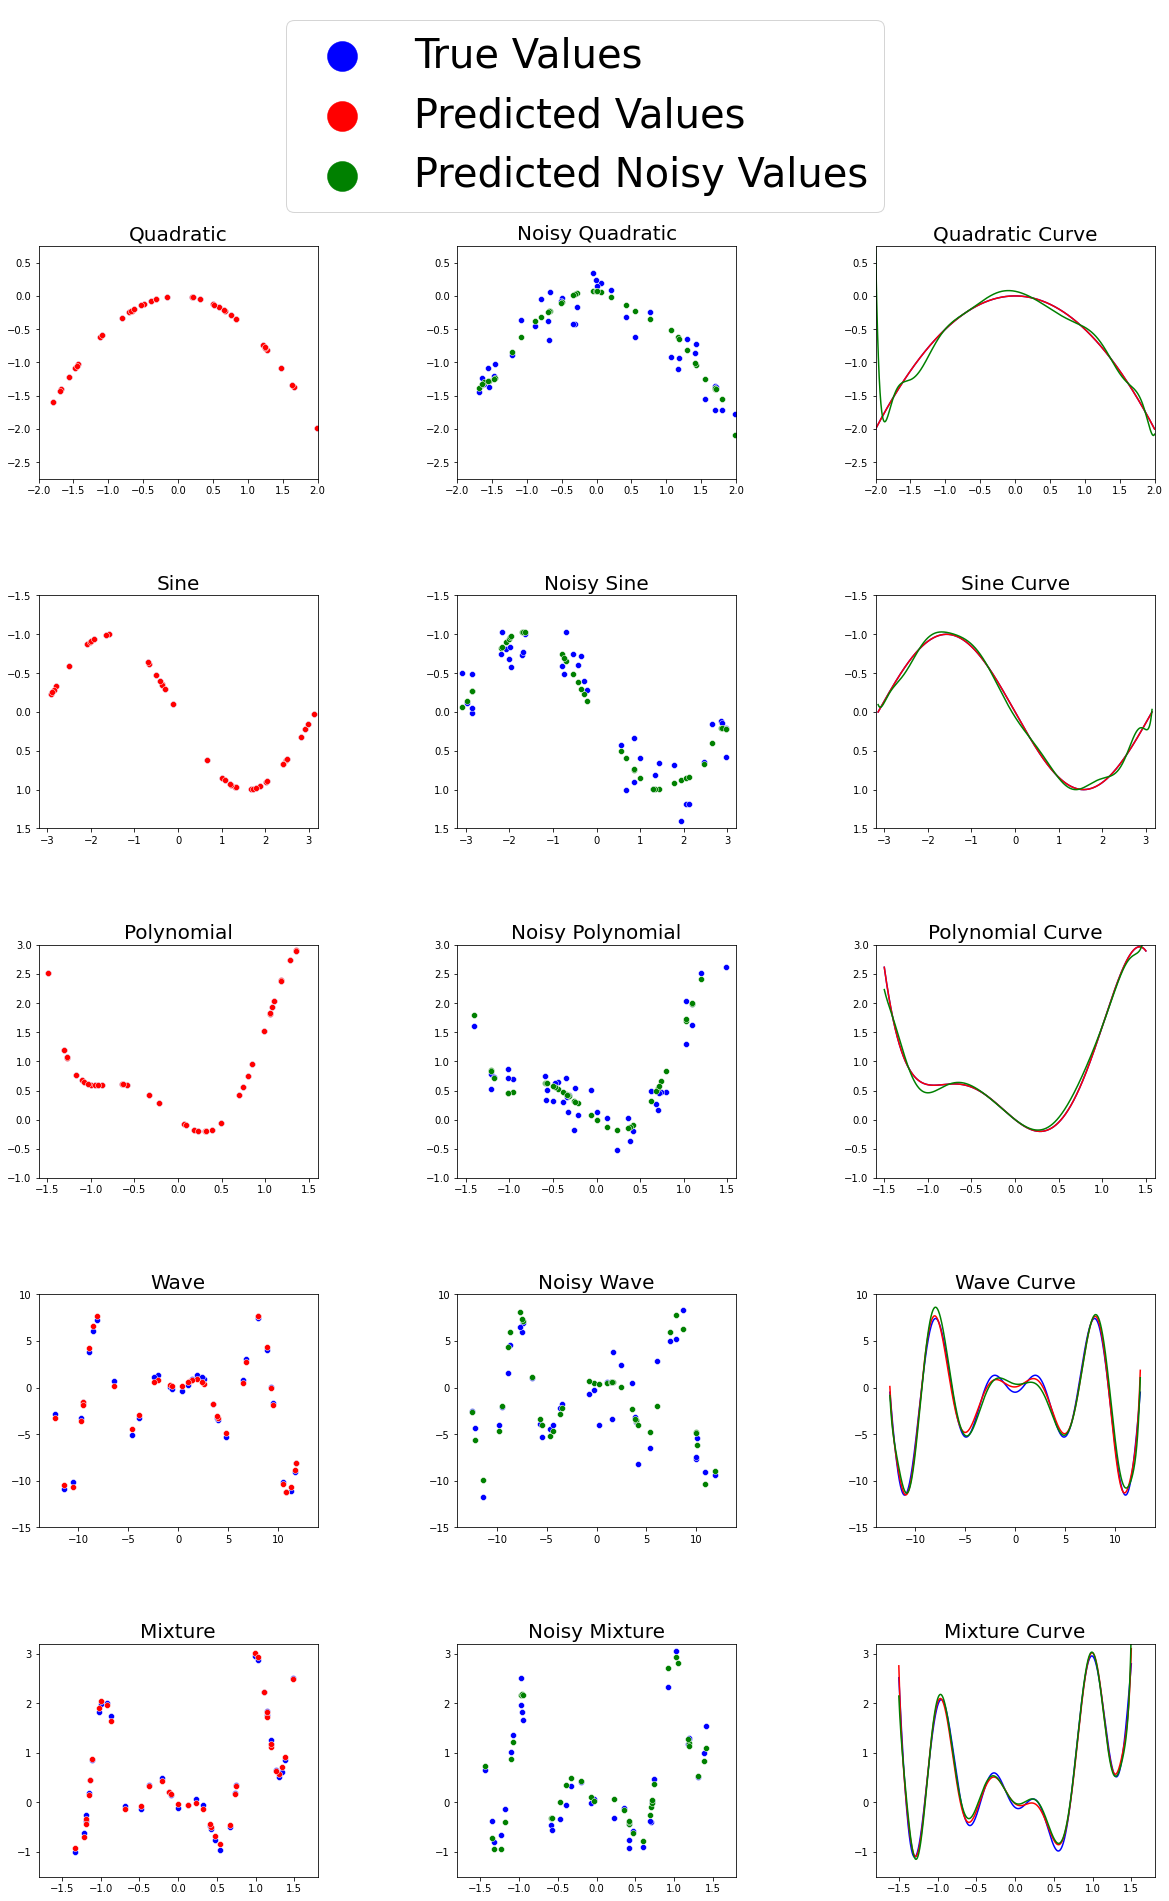

In [54]:
# Display the MSE
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=np.flip(np.rot90(np.array([distribution_list, model_errors[0:5],
                                                     model_errors[5:10], model_errors[5:10] - model_errors[0:5]])), 0),
                 colLabels=['Distribution', 'Test Error', 'Noisy Test Error', 'Error Difference'], loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(20)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

# Plot the model's predictions
fig, axes = plt.subplots(5, 3, figsize=(20,30), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
for i, axis in enumerate(np.flip(np.rot90(axes), axis=0).flatten()):

    # Display the distribution name and markings
    if i < 5: title = distribution_list[i % 5]
    elif i < 10: title = 'Noisy ' + distribution_list[i % 5]
    else: title = distribution_list[i % 5] + ' Curve'
    axis.set_title(title, fontsize=20)

    # Find the values to plot
    if i < 5: data_X = X_test_list[i]
    elif i < 10: data_X = X_noisy_test_list[i-5]
    else: data_X = X_true_list[i % 5]

    if i < 5: data_y = y_test_list[i]
    elif i < 10: data_y = y_noisy_test_list[i-5]
    else: data_y = y_true_list[i % 5]

    # Find the color of the predicted values
    if i < 5: color = 'red'
    else: color = 'green'

    # Plot the test values
    if i < 10: sns.scatterplot(x=data_X, y=data_y, ax=axis, color='blue')
    else: sns.lineplot(x=data_X, y=data_y, ax=axis, color='blue', sort=False)

    # Plot the predicted values
    if i < 10: sns.scatterplot(x=data_X, y=model_predictions[i], ax=axis, color=color)
    else:
        sns.lineplot(x=data_X, y=model_predictions[i], ax=axis, color='red', sort=False)
        sns.lineplot(x=data_X, y=model_predictions[i+5], ax=axis, color='green', sort=False)

    # Set the plot limits
    axis.set_xlim(plot_bounds[0][i % 5])
    axis.set_ylim(plot_bounds[1][i % 5])

leg = fig.legend(labels=['True Values', 'Predicted Values', 'Predicted Noisy Values'],
                 markerscale=5,loc='upper center', prop={'size': 40})
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
leg.legendHandles[2].set_color('green')
plt.show()